In [1]:
import tensorflow as tf
import numpy as np
import scipy
import pandas as pd

import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
import glob, os, sys, gc
import skimage

plt.style.use('ggplot')
sys.path.insert(0,'..') # add parent directory to path
from prior_attention import build_prior_attentions
import utils
from config import Config

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM
from keras import optimizers
from keras.optimizers import Adam

# this is important to make sure the Config is reloaded when modified
%load_ext autoreload
%autoreload 2
# %pprint

Using TensorFlow backend.


In [2]:
dict(vars(Config))

{'__module__': 'config',
 'main_path': '/home/mikey/Data/POETdataset/PascalImages',
 'class_names': ['dog',
  'aeroplane',
  'boat',
  'bicycle',
  'cat',
  'cow',
  'diningtable',
  'horse',
  'motorbike',
  'sofa'],
 'IMG_SIZE': 480,
 'PATCH_WIDTH': 60,
 'SMALLER_IMG_SIZE': 150,
 'T': 64,
 'new_dir': 'soft_attention_features_60',
 'new_dir_img': 'soft_attention_images_60',
 'name_to_class_dict': {'dog': 0,
  'aeroplane': 1,
  'boat': 2,
  'bicycle': 3,
  'cat': 4,
  'cow': 5,
  'diningtable': 6,
  'horse': 7,
  'motorbike': 8,
  'sofa': 9},
 'train_ids': ['horse_2010_004477.jpg',
  'cat_2010_001351.jpg',
  'horse_2008_006434.jpg',
  'dog_2010_002586.jpg',
  'cat_2008_007239.jpg',
  'cat_2010_002305.jpg',
  'cat_2009_003419.jpg',
  'sofa_2008_004670.jpg',
  'cow_2009_003189.jpg',
  'dog_2010_002808.jpg',
  'horse_2009_000409.jpg',
  'diningtable_2010_004361.jpg',
  'dog_2009_001535.jpg',
  'cat_2011_000973.jpg',
  'cow_2010_001694.jpg',
  'sofa_2011_001192.jpg',
  'cat_2009_001037.jpg

In [3]:
main_path = Config.main_path
class_names = Config.class_names
IMG_SIZE = Config.IMG_SIZE
PATCH_WIDTH = Config.PATCH_WIDTH
SMALLER_IMG_SIZE = Config.SMALLER_IMG_SIZE
T = Config.T
new_dir = Config.new_dir
new_dir_img = Config.new_dir_img
name_to_class_dict = Config.name_to_class_dict
train_ids, test_ids = Config.train_ids, Config.test_ids

In [4]:
def load_data(mode):
    X = []
    y = []
    org_images = []
    all_ids = []
    for class_name, class_number in name_to_class_dict.items():
        classfeatures_path = os.path.abspath(os.path.join('.', new_dir, class_name + '_' + mode + '_features.pkl'))
        classimages_path = os.path.abspath(os.path.join('.', new_dir_img, class_name + '_' + mode + '.pkl'))
        print(classfeatures_path)

        features = np.asarray(utils.load_object(classfeatures_path).reshape(-1,T,2048), dtype=np.float32)
        images = np.asarray(utils.load_object(classimages_path), dtype=np.float32)
        ids = utils.load_object(new_dir + os.path.sep + class_name + '_'+mode+'_names.pkl')
        org_images.append(images)

        print(features.shape)
        X.append(features)
        y.append([class_number] * features.shape[0])
        all_ids.append(ids)

    X = np.concatenate(X)
    y = np.concatenate(y)
    y = keras.utils.to_categorical(y)
    ids = np.concatenate(all_ids)
    org_images = np.concatenate(org_images)
    return X, y, org_images, ids
    
X_train, y_train, images_train, train_ids = load_data(mode='train')
X_test, y_test, images_test, test_ids = load_data(mode='test')

X_train.shape, y_train.shape, images_train.shape, X_test.shape, y_test.shape, images_test.shape

/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_model/soft_attention_features_60/dog_train_features.pkl
(1128, 64, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_model/soft_attention_features_60/aeroplane_train_features.pkl
(599, 64, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_model/soft_attention_features_60/boat_train_features.pkl
(454, 64, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_model/soft_attention_features_60/bicycle_train_features.pkl
(480, 64, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_model/soft_attention_features_60/cat_train_features.pkl
(943, 64, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_model/soft_attention_features_60/cow_train_features.pkl
(265, 64, 2048)
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/soft_attention_model/soft_attention_features_60/diningtable_train_features

((5517, 64, 2048),
 (5517, 10),
 (5517, 150, 150, 3),
 (614, 64, 2048),
 (614, 10),
 (614, 150, 150, 3))

In [5]:
tf.reset_default_graph()

n_epochs = 100
batch_size = 32
T = X_train.shape[1]
lstm_time = 3 #analogous to fixations ?
regularize_attention = True
pretrain_attention = False
prior_attentions_train = build_prior_attentions(utils.load_object('../train_fix.pkl'), T, lstm_time, gauss_sigma=None)
prior_attentions_test = build_prior_attentions(utils.load_object('../test_fix.pkl'), T, lstm_time, gauss_sigma=None)

               
X_input = tf.placeholder(tf.float32, [None, T, 2048], name='X')
prior_attentions_input = tf.placeholder(tf.float32, [None, lstm_time, T])
labels = tf.placeholder(tf.int32, [None, y_train.shape[1]], name='labels')

rnn_units = 32

# c,h = utils._get_initial_lstm(X_input[:,:,:], H=rnn_units)

context = tf.layers.dense(tf.reshape(X_input, shape=(-1, T*2048)), rnn_units, activation='tanh')
c = tf.layers.dense(tf.reshape(X_input, shape=(-1, T*2048)), rnn_units, activation='tanh')
h = tf.layers.dense(tf.reshape(X_input, shape=(-1, T*2048)), rnn_units, activation='tanh')
# context = tf.layers.dropout(context, rate=0.1)

lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=rnn_units)

contexts = []
attentions = []

att_input = tf.nn.tanh(X_input) # squeeze features from Resnet into same scale as context

AttentionDense = tf.layers.Dense(T, activation='tanh')

kernel_reg, activity_reg = None, None
if regularize_attention:
    kernel_reg, activity_reg = (tf.contrib.layers.l2_regularizer(scale=.0005),
                                tf.contrib.layers.l2_regularizer(scale=.0005))

ContextDense = tf.layers.Dense(2048, activation='tanh',
                              kernel_regularizer=kernel_reg,
                              activity_regularizer=activity_reg)
for t in range(lstm_time):
    # encoded lstm context to a specific size 
    context_transformed = ContextDense(context)
#     context_transformed = tf.layers.dropout(context_transformed, rate=0.1)
    
    # how lstm context and patch info relate
    att = tf.einsum('bi,bti->bt', context_transformed, att_input)
#     att_input = tf.layers.dense(tf.reshape(X_input, shape=(-1, T*2048)), T, activation='tanh')

#     att = AttentionDense(tf.concat([context, att_input], axis=1))
    att = tf.nn.softmax(att)
    
    lstm_input = tf.einsum('bt,bti->bi', att, X_input)
    
    context, (c, h) = lstm_cell(inputs=lstm_input, state=[c, h])
    context = tf.layers.dropout(context, rate=0.5)
    contexts.append(context)
    attentions.append(att)
    
all_attentions_tensor = tf.transpose(tf.stack(attentions), [1,0,2])
attention_loss = tf.reduce_mean(tf.abs(tf.exp(tf.abs(all_attentions_tensor - tf.nn.softmax(prior_attentions_input))) - 1))
attention_loss = tf.reduce_mean(tf.abs(all_attentions_tensor - (prior_attentions_input)))

Dense = tf.layers.Dense(units=32, activation=tf.nn.relu)
Logits = tf.layers.Dense(units=y_train.shape[1])
probabilities_list = []
for context in contexts:
    dense = Dense(context)
    dense = tf.layers.dropout(dense, rate=0.7)

    # Logits Layer
    logits = Logits(dense)
    logits = tf.layers.dropout(logits, rate=0.7)

    classes = tf.argmax(logits, axis=1)
    probabilites = tf.nn.softmax(logits)
    probabilities_list.append(probabilites)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits))
l2_loss = tf.losses.get_regularization_loss()
loss += l2_loss

regular_loss_multiplier = tf.placeholder_with_default(1.0, shape=(), name='regular_loss_multiplier')
attention_loss_multiplier = tf.placeholder_with_default(0., shape=(), name='attention_loss_multiplier')

final_loss = regular_loss_multiplier * loss + attention_loss_multiplier * attention_loss

learning_rate = tf.placeholder(tf.float32, name='learning_rate')

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(
    loss=final_loss,
    global_step=tf.train.get_global_step()
)

accuracy = tf.reduce_mean(tf.cast(tf.equal(classes, tf.argmax(labels, 1)), tf.float32))

init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


Crucial points for high accuracy:
- regularization on attention
- shuffle after every epoch
- lstm time doesn't matter much (run experiments)
- some dropout to make sure it isn't stuck in local minima

In [6]:
saver = tf.train.Saver(max_to_keep=1)
with tf.Session() as sess:
    sess.run(init)
    
    training_attention = pretrain_attention
    learning_rate_ = 0.0001
    if training_attention:
        learning_rate_ = 0.00001
    
    changed_learning_rate = False
    train_acc_list = []
    acc_list = []
    for epoch in range(n_epochs):
        if training_attention: # training attention
            att_loss_multiplier_value = 1.
            regular_loss_multiplier_value = 0.
        elif pretrain_attention: # switched from training attention to not training
            att_loss_multiplier_value = 10.
            regular_loss_multiplier_value += .1
            if regular_loss_multiplier_value > 1:
                regular_loss_multiplier_value = 1.
                att_loss_multiplier_value = 0.
        else: # wasn't training attention in the first place
            att_loss_multiplier_value = 0.
            regular_loss_multiplier_value = 1.
            
        print("Epoch:", epoch)
        train_acc = []
        att_losses = []
        for b in range(0, X_train.shape[0], batch_size):
            _, acc, loss_, att_loss_ = sess.run([train_op, accuracy, final_loss, attention_loss], feed_dict={
                                                            X_input: X_train[b:b+batch_size],
                                                            prior_attentions_input: prior_attentions_train[b:b+batch_size],
                                                            labels: y_train[b:b+batch_size],
                                                            learning_rate: learning_rate_,
                                                            attention_loss_multiplier: att_loss_multiplier_value,
                                                            regular_loss_multiplier: regular_loss_multiplier_value
                                                        })
            train_acc.append(acc)
            att_losses.append(att_loss_)
            
        # reshuffle after every epoch
        if not training_attention:
#             X_train, y_train, prior_attentions, images_train = \
#                 utils.unison_shuffled_copies([X_train, y_train, prior_attentions_train, images_train])
            
            acc, context_, atts_, test_proba_, probabilities_list_, att_loss_test = \
                sess.run([accuracy,
                          context, all_attentions_tensor, probabilites,
                          probabilities_list,
                         attention_loss], 
                         feed_dict={
                                    X_input: X_test[:],
                                    labels: y_test[:],
                                    prior_attentions_input: prior_attentions_test[:],
                                    })
            if acc > 0.8 and not changed_learning_rate:
                learning_rate_ = learning_rate_ / 10.
                changed_learning_rate = True
                print("Adjusted learning rate to", learning_rate_)

            if acc > 0.97:
                break
        else:
            acc, context_, atts_, test_proba_, probabilities_list_, att_loss_test = \
                sess.run([accuracy,
                          context, all_attentions_tensor, probabilites,
                          probabilities_list,
                         attention_loss], 
                         feed_dict={
                                    X_input: X_test[:],
                                    labels: y_test[:],
                                    prior_attentions_input: prior_attentions_test[:],
                                    })
                     
        print("Train:", np.mean(train_acc))
        print("Test:", acc)
        print("Attention loss", np.mean(att_losses))
        print("Attention loss test", att_loss_test)
        train_acc_list.append(np.mean(train_acc))
        acc_list.append(acc)
        train_acc = []
        att_losses = []
        
        if len(acc_list) > 1 and acc > np.max(acc_list[:-1]):
            saver.save(sess, './checkpoint' + str(Config.PATCH_WIDTH) + '/model-with-attention')
        
#         0.0303
#         0.111
        if training_attention and att_loss_test < 0.05:
            training_attention = False
            print("Done training prior attention")
            learning_rate_ = learning_rate_ * 10
#             break
#         print(atts_[0])

Epoch: 0
Train: 0.1517341
Test: 0.078175895
Attention loss 0.03077884
Attention loss test 0.030974768
Epoch: 1
Train: 0.1013367
Test: 0.23289903
Attention loss 0.030678479
Attention loss test 0.030613996
Epoch: 2
Train: 0.2829591
Test: 0.34527686
Attention loss 0.030677583
Attention loss test 0.03041676
Epoch: 3
Train: 0.32143453
Test: 0.4136808
Attention loss 0.03061723
Attention loss test 0.03056331
Epoch: 4
Train: 0.33127224
Test: 0.4820847
Attention loss 0.030621203
Attention loss test 0.030466294
Epoch: 5
Train: 0.43937585
Test: 0.51302934
Attention loss 0.030612582
Attention loss test 0.03048967
Epoch: 6
Train: 0.49202424
Test: 0.5635179
Attention loss 0.030615503
Attention loss test 0.030551463
Epoch: 7
Train: 0.51785517
Test: 0.60749185
Attention loss 0.030626051
Attention loss test 0.030513262
Epoch: 8
Train: 0.58585757
Test: 0.63355047
Attention loss 0.03063577
Attention loss test 0.030491209
Epoch: 9
Train: 0.6240829
Test: 0.65798044
Attention loss 0.030635167
Attention loss

KeyboardInterrupt: 

In [6]:
saver = tf.train.Saver(max_to_keep=1)
with tf.Session() as sess:
    sess.run(init)
#     new_saver = tf.train.import_meta_graph('./checkpoint/model-with-attention.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./checkpoint' + str(Config.PATCH_WIDTH)))

    acc, context_, atts_, test_proba_, probabilities_list_, att_loss_test = \
        sess.run([accuracy,
                  context, all_attentions_tensor, probabilites,
                  probabilities_list,
                 attention_loss], 
                 feed_dict={
                            X_input: X_test,
                            labels: y_test,
                            prior_attentions_input: prior_attentions_test,
                            })
    print("Test:", acc)
    print("Attention loss", att_loss_test)

INFO:tensorflow:Restoring parameters from ./checkpoint60/model-with-attention
Test: 0.8013029
Attention loss 0.030403767


In [7]:
np.array(context_).shape, np.array(atts_).shape

((614, 32), (614, 3, 64))

In [8]:
atts_ = np.array(atts_)
images_test = np.array(images_test)
probabilities_list_ = np.array(probabilities_list_)

atts_.shape

(614, 3, 64)

In [9]:
unique, counts = np.unique(np.argmax(y_test, axis=-1), return_counts=True)
class_to_name_dict = {v:k for k,v in name_to_class_dict.items()}
unique = np.array([class_to_name_dict[u] for u in unique])

np.asarray((unique, counts)).T

array([['dog', '126'],
       ['aeroplane', '67'],
       ['boat', '50'],
       ['bicycle', '53'],
       ['cat', '105'],
       ['cow', '30'],
       ['diningtable', '47'],
       ['horse', '48'],
       ['motorbike', '50'],
       ['sofa', '38']], dtype='<U21')

In [10]:
unique, counts = np.unique(np.argmax(test_proba_, axis=-1), return_counts=True)
class_to_name_dict = {v:k for k,v in name_to_class_dict.items()}
unique = np.array([class_to_name_dict[u] for u in unique])

np.asarray((unique, counts)).T

array([['dog', '105'],
       ['aeroplane', '63'],
       ['boat', '54'],
       ['bicycle', '47'],
       ['cat', '109'],
       ['cow', '17'],
       ['diningtable', '42'],
       ['horse', '69'],
       ['motorbike', '62'],
       ['sofa', '46']], dtype='<U21')

In [11]:
from scipy import signal
from scipy import ndimage

def get_attention_result(img, attention, patches_n, img_size, patch_width, scale = 8, gauss_sigma=None):
    result = np.zeros_like(img)
    for attended_patch_n in range(patches_n):
        att_prob = attention[attended_patch_n]

        row = int(attended_patch_n/(img_size/patch_width))
        col = int(attended_patch_n%(img_size/patch_width))

        from_y = row*patch_width
        to_y = from_y+patch_width

        from_x = col*patch_width
        to_x = from_x+patch_width
        
        result[from_y:to_y, from_x:to_x, :] = np.ones_like(result[from_x:to_x,from_y:to_y,:]) * 255 * att_prob
    
    result = result / 255.
    if gauss_sigma:
        result = ndimage.gaussian_filter(result, sigma=gauss_sigma)
    
    result = result * scale
    result[result > 1] = 1
    
    img = img / 255.
    return utils.normalize((scale/20) * img + result), result

In [12]:
name_to_fix_test = {name:fix for fix, name in zip(utils.load_object('../test_fix.pkl'), utils.load_object('../test_ids.pkl'))}

In [13]:
probabilities_list_.shape

(3, 614, 10)

In [14]:
probabilities_list_ = np.transpose(probabilities_list_, [1,0,2])

In [15]:
human_heatmaps = np.load('../cam/heatmaps_resized.npy').tolist()

In [16]:
class_to_name_dict

{0: 'dog',
 1: 'aeroplane',
 2: 'boat',
 3: 'bicycle',
 4: 'cat',
 5: 'cow',
 6: 'diningtable',
 7: 'horse',
 8: 'motorbike',
 9: 'sofa'}

In [17]:
from collections import Counter
counter_dict = {key: 0 for key in dict(Counter([el.split('_')[0] for el in np.array(test_ids)])).keys()}
counter_dict

{'dog': 0,
 'aeroplane': 0,
 'boat': 0,
 'bicycle': 0,
 'cat': 0,
 'cow': 0,
 'diningtable': 0,
 'horse': 0,
 'motorbike': 0,
 'sofa': 0}

In [20]:
def translate_prob_res(prob_res, int_to_string_classmap):
    return [(int_to_string_classmap[el[0]], el[1]) for el in prob_res]

In [27]:
def pearson(a, b):
    return scipy.stats.pearsonr(a.reshape(-1,), b.reshape(-1,))[0]

class_name = 'aeroplane'
class_id = name_to_class_dict[class_name]
class_mask = np.argmax(y_test, axis=1) == class_id

# class_images = images_test[class_mask]
# class_test_proba = test_proba_[class_mask]
# class_proba_list = probabilities_list_[class_mask,:,:]
# class_atts = atts_[class_mask,:,:]
# class_true_atts = prior_attentions_test[class_mask]

class_images = images_test
class_test_proba = test_proba_
class_proba_list = probabilities_list_
class_atts = atts_
class_true_atts = prior_attentions_test

print(class_proba_list.shape)
rescale = IMG_SIZE / SMALLER_IMG_SIZE

image_n = 7
# image_name = np.array(test_ids)[class_mask][image_n]
image_name = np.array(test_ids)[image_n]

results = {}
def construct_res(att_human_steps, att_computer_steps, ground_truth_heatmap, heatmap, proba_res_list):
    assert type(proba_res) == list
    
    ah, bh, ch = att_human_steps
    ac, bc, cc = att_computer_steps
    
    def get_hm_dict(gt, hm):
        return{
            'hm': hm,
            'pcc': pearson(np.abs(hm), gt)
        }
    def get_att_dict(h, c):
        return{
            'computer': c,
            'human': h
        }
    return {
        'avg_heatmap': get_hm_dict(ground_truth_heatmap, heatmap),
        'attention_vis':{
            'a': get_att_dict(ah, ac),
            'b': get_att_dict(bh, bc),
            'c': get_att_dict(ch, cc)
        },
        'prob_res':{
            'a': proba_res_list[0],
            'b': proba_res_list[1],
            'c': proba_res_list[2]
        }
    }


col_names = ['id', 'true_class', 'soft_prediction', 'soft_certainty', 'soft_pcc', 'soft_all_probas']
df = pd.DataFrame(columns=col_names)


from tqdm import tqdm
for image_n in tqdm(list(range(images_test.shape[0]))[:]):
    image_name = np.array(test_ids)[image_n]
    image_class = image_name.split('_')[0]
#     if counter_dict[image_class] > 9:
#         continue
        
    counter_dict[image_class] += 1
    
    print(image_name)
    print(name_to_fix_test[image_name])
    
    ground_truth_heatmap = human_heatmaps[image_name]
    
    att_results = []
    overlay_results = []
    proba_res_list = []
    att_human_steps = []
    att_computer_steps = []
    for t in range(atts_.shape[1]):
        image = class_images[image_n]
        proba_res = class_proba_list[image_n,t,:]
    #     print(proba_res)
    #     print(class_to_name_dict[np.argmax(proba_res)])
        proba_res = [(i, proba) for i, proba in enumerate(proba_res)]
        proba_res.sort(key= lambda pair: pair[1], reverse=True)
    #     print(proba_res)
        for i, proba in enumerate(proba_res):
            print(class_to_name_dict[proba[0]], proba[1])
        proba_res_list.append(proba_res)

        if rescale != 1:
            chosen_img = np.array(utils.normalize(skimage.transform.rescale(image.copy(), rescale))) * 500
        else:
            chosen_img = image.copy()
#         print(chosen_img.shape)

        chosen_attention = class_atts[image_n,t,:]
        chosen_true_attention = class_true_atts[image_n,t,:]
        print(np.mean(np.abs(chosen_attention - chosen_true_attention)))

        result, att = get_attention_result(chosen_img, chosen_attention, T, IMG_SIZE, PATCH_WIDTH, scale=8, gauss_sigma=None)
#         plt.imshow(result)
#         plt.grid(False)
#         plt.show()
        att_human_steps.append(np.asarray(result, dtype=np.float16))

        att_results.append(att)

        result, att = get_attention_result(chosen_img, chosen_true_attention, T, IMG_SIZE, PATCH_WIDTH, scale=8, gauss_sigma=None)
        att_computer_steps.append(np.asarray(result, dtype=np.float16))
#         plt.imshow(result)
#         plt.grid(False)
#         plt.show()

#         plt.bar(range(atts_.shape[2]), chosen_attention)
#         plt.show()

#     for hm in att_results:
#         plt.imshow(hm[:,:,0], cmap='jet')
#         plt.colorbar()
#         plt.show()

#     plt.imshow(np.mean(att_results, axis=0)[:,:,0], cmap='jet')
    heatmap = np.mean(att_results, axis=0)[:,:,0]
    heatmap = skimage.transform.resize(heatmap, output_shape=(224,224))
    heatmap = np.asarray(heatmap, dtype=np.float16)
#     plt.colorbar()
#     plt.show()
    
    res = construct_res(att_human_steps, att_computer_steps, 
                 human_heatmaps[image_name], heatmap, proba_res_list)
#     print(res.keys())
    
    final_prob_string = translate_prob_res(res['prob_res']['c'], class_to_name_dict)
    row = [
        image_name,
        image_class,
        final_prob_string[0][0],
        final_prob_string[0][1],
        res['avg_heatmap']['pcc'],
        final_prob_string
    ]
    df = df.append({key: value for key,value in zip(col_names, row)}, ignore_index=True)
#     plt.imshow(utils.normalize(image))
#     plt.grid(False)
#     plt.show()

NameError: name 'name_to_class_dict' is not defined

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv('softstat.csv', index_col=0)
df.head()

,id,true_class,soft_prediction,soft_certainty,soft_pcc,soft_all_probas
0,dog_2008_003665.jpg,dog,dog,0.627715,0.089912,"[('dog', 0.6277153), ('cat', 0.13424954), ('ho..."
1,dog_2011_001543.jpg,dog,cat,0.671896,0.049949,"[('cat', 0.67189634), ('dog', 0.26952815), ('c..."
2,dog_2010_000395.jpg,dog,cat,0.972907,0.449007,"[('cat', 0.9729066), ('dog', 0.014079208), ('h..."
3,dog_2008_004647.jpg,dog,dog,0.432034,0.249341,"[('dog', 0.43203354), ('horse', 0.21311668), (..."
4,dog_2009_000600.jpg,dog,dog,0.959290,0.276240,"[('dog', 0.95928985), ('cow', 0.023589429), ('..."


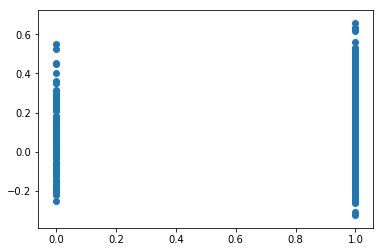

In [9]:
correct_mask = df['true_class'] == df['soft_prediction']
plt.scatter(df['true_class'] == df['soft_prediction'], df['soft_pcc'])

In [10]:
df[np.logical_not(correct_mask)].describe()

,soft_certainty,soft_pcc
count,122.000000,122.000000
mean,0.603228,0.077429
std,0.213162,0.176099
min,0.188199,-0.251739
25%,0.432071,-0.075711
50%,0.617570,0.078870
75%,0.798685,0.222345
max,0.987043,0.551170


In [11]:
df[correct_mask].describe()

,soft_certainty,soft_pcc
count,492.000000,492.000000
mean,0.820427,0.128218
std,0.185447,0.183285
min,0.205529,-0.323534
25%,0.729348,-0.000038
50%,0.903307,0.120865
75%,0.961259,0.245481
max,0.987839,0.657354


Text(0, 0.5, 'Count')

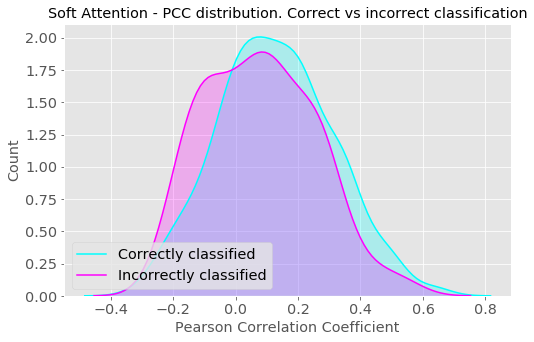

In [23]:
import seaborn as sns

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

c1,c2 = 'magenta', 'cyan'
fig = sns.kdeplot(df[correct_mask]['soft_pcc'], shade=True, color=c2, label='Correctly classified')
fig = sns.kdeplot(df[np.logical_not(correct_mask)]['soft_pcc'], shade=True, color=c1, label='Incorrectly classified')
plt.legend(loc=3)
plt.title("Soft Attention - PCC distribution. Correct vs incorrect classification")
plt.xlabel("Pearson Correlation Coefficient")
plt.ylabel("Count")

(array([ 2.,  0.,  0.,  5.,  4.,  6.,  4.,  5.,  8.,  8.,  6.,  9.,  9.,
        14., 18., 14., 22., 18., 26., 19., 12., 24., 24., 12., 20., 20.,
        15., 24., 21., 13.,  8., 11., 14., 13., 15.,  9.,  5.,  6.,  4.,
         4.,  2.,  7.,  5.,  2.,  0.,  1.,  0.,  1.,  2.,  1.]),
 array([-0.32353369, -0.30391593, -0.28429817, -0.26468041, -0.24506265,
        -0.22544489, -0.20582713, -0.18620937, -0.16659161, -0.14697385,
        -0.12735609, -0.10773833, -0.08812057, -0.06850281, -0.04888505,
        -0.02926729, -0.00964953,  0.00996823,  0.02958599,  0.04920375,
         0.06882151,  0.08843927,  0.10805703,  0.1276748 ,  0.14729256,
         0.16691032,  0.18652808,  0.20614584,  0.2257636 ,  0.24538136,
         0.26499912,  0.28461688,  0.30423464,  0.3238524 ,  0.34347016,
         0.36308792,  0.38270568,  0.40232344,  0.4219412 ,  0.44155896,
         0.46117672,  0.48079448,  0.50041224,  0.52003   ,  0.53964776,
         0.55926552,  0.57888328,  0.59850104,  0.6181188 ,

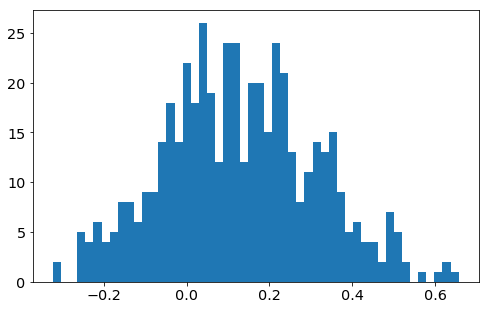

In [13]:
plt.hist(df[correct_mask]['soft_pcc'], bins=50)

,soft_certainty,soft_pcc
count,122.000000,122.000000
mean,0.603228,0.077429
std,0.213162,0.176099
min,0.188199,-0.251739
25%,0.432071,-0.075711
50%,0.617570,0.078870
75%,0.798685,0.222345
max,0.987043,0.551170


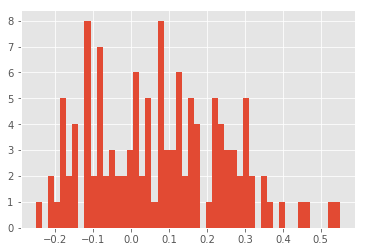

In [55]:
plt.hist(df[np.logical_not(correct_mask)]['soft_pcc'], bins=50)

Text(0, 0.5, 'Highest prediction probability')

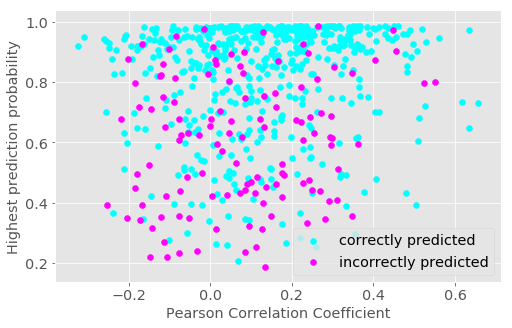

In [35]:
plt.scatter(df[correct_mask]['soft_pcc'], df[correct_mask]['soft_certainty'], c='cyan', label='correctly predicted')
plt.scatter(df[np.logical_not(correct_mask)]['soft_pcc'], df[np.logical_not(correct_mask)]['soft_certainty'], c='magenta', label='incorrectly predicted')
plt.legend()
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Highest prediction probability')

In [31]:
def pearson(a, b):
    return scipy.stats.pearsonr(a, b)[0]

pearson(df[correct_mask]['soft_pcc'], df[correct_mask]['soft_certainty']), pearson(df[np.logical_not(correct_mask)]['soft_pcc'], df[np.logical_not(correct_mask)]['soft_certainty'])

(0.10078557594181695, 0.1462317878417367)

In [36]:
pearson(df['soft_pcc'], df['soft_certainty'])

0.14557940855451318

In [67]:
def save_object(obj, path):
    with open(path, 'wb') as f:
        np.savez(f, obj)   
        
def load_object(path):
    with open(path, 'rb') as f:
        ret_di = np.load(f)
    return ret_di

utils.save_object(results, 'soft_att_results.pkl')
utils.save_object(class_to_name_dict, 'soft_classmap.pkl')

In [68]:
hm_test = utils.load_object('soft_att_results.pkl')
class_map = utils.load_object('soft_classmap.pkl')

In [76]:
def overlay_heatmap(org_img, heatmap, gauss_sigma=None, thresh=None, normalize=False, absolute=False):
    img = org_img/255
    if absolute:
        heatmap = np.abs(heatmap)
    
    if thresh:
        heatmap[heatmap < thresh] = 0
    
    if normalize:
        heatmap = utils.normalize(heatmap)
        
#     print(np.min(heatmap), np.max(heatmap))
    if gauss_sigma is not None:
        heatmap = scipy.ndimage.filters.gaussian_filter(heatmap, sigma=gauss_sigma)
    
    if not normalize:
        heatmap = heatmap / 40
    
    heatmap_jet = plt.imshow(heatmap, cmap='jet')
    
    if normalize:
        pass
    else:
        if absolute:
            plt.clim(0,1)
        else:
            plt.clim(-1,1)
    
    colorbar = plt.colorbar()
#     print(colorbar)
#     plt.show()
    
    heatmap_jet.write_png('heatmap.png')
    heatmap_jet_ld = scipy.misc.imread('heatmap.png')
    heatmap_jet_ld = heatmap_jet_ld/ 255
    alpha = 0.5
    

    out_img = np.zeros(img.shape,dtype=img.dtype)
    out_img[:,:,0] = alpha*img[:,:,0] + (1-alpha)* heatmap_jet_ld[:,:,0]
    out_img[:,:,1] = alpha*img[:,:,1] + (1-alpha)* heatmap_jet_ld[:,:,1]
    out_img[:,:,2] = alpha*img[:,:,2] + (1-alpha)* heatmap_jet_ld[:,:,2]

    return out_img, colorbar

def print_proba_results(proba_res, class_to_name_dict):
    for key, value in proba_res.items():
        print(key)
        for i, proba in enumerate(value):
            print(class_to_name_dict[proba[0]], proba[1])

name = list(hm_test.keys())[1]

keys_to_vis = ['avg_heatmap']

def visualize(name, heatmap_results_list, class_map):    
    hm_results = heatmap_results_list[name]
    print("Prediction results:")
    print_proba_results(hm_results['prob_res'], class_map)
    
    for key in keys_to_vis:
        hm_result = hm_results[key]
        img, colorbar = overlay_heatmap(hm_results['image'], hm_result['hm'], 
                                        normalize=(key == 'ground_truth'), absolute=True)
        plt.imshow(img, cmap='jet')
        # plt.colorbar()
        frame1 = plt.gca()
        frame1.axes.xaxis.set_ticks([])
        frame1.axes.yaxis.set_ticks([])
        plt.show()
        if key == 'first_prob':
            print("Prediction:", inv_class_map[hm_results['prob_res'][0][0]])
        elif key == 'second_prob':
            print("Prediction:", inv_class_map[hm_results['prob_res'][1][0]])
        elif key == 'correct':
            for res in hm_results['prob_res']:
                class_n, prob = res
                if inv_class_map[class_n] == name.split('_')[0]:
                    print("Prediction:", inv_class_map[class_n])
        
        print("Perason correlation with ground truth:", hm_result['pcc'])
    
visualize(name, hm_test, class_map)

Prediction results:
a
sofa 0.120653816
horse 0.10175295
diningtable 0.10169232
bicycle 0.09856464
boat 0.09821884
aeroplane 0.09736609
cow 0.09716684
cat 0.09679294
dog 0.0961012
motorbike 0.09169041
b
dog 0.12956104
sofa 0.1227167
boat 0.12205834
horse 0.121937424
cow 0.11842498
aeroplane 0.10065684
diningtable 0.08196125
cat 0.077993974
motorbike 0.065157324
bicycle 0.05953217
c
cat 0.67189634
dog 0.26952815
cow 0.0273471
horse 0.022087788
diningtable 0.0037564728
sofa 0.002374566
boat 0.002049806
motorbike 0.00067645276
bicycle 0.0001841455
aeroplane 9.915589e-05


KeyError: 'image'

In [ ]:
y_pred_proba = test_proba_

y_pred = np.argmax(y_pred_proba, axis=1)

y_test_argmax = np.argmax(y_test, axis=1)

y_test_argmax.shape



plt.figure(figsize=(12,12))
fig = plot_confusion_matrix(y_test_argmax, y_pred, class_names, normalize=True)

In [ ]:
class_proba_list.shape

In [ ]:
# files_list = [glob.glob(os.path.join(main_path, '%s*' %class_)) for class_ in class_names]

# ids_ = []
# final_files_list = []
# labels = []
# for label, files in enumerate(files_list):
#     one_list = []
#     for file in files:
#         id_ = ''.join(file.split('/')[-1].split('.')[0].split('_')[1:])
#         if id_ not in ids_:
#             one_list.append(file)
#             ids_.append(id_)
#             labels.append(label)
#     final_files_list.append(one_list)
    

# files_dict = {class_name.replace('*', ''): class_files for class_name, class_files in zip(class_names, final_files_list)}